<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/PeriodicBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

dolfin version: 2018.1.0


/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'interactive'
  s)


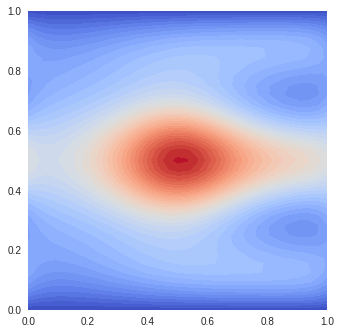

In [6]:
from dolfin import *

# Source term
class Source(UserExpression):
    def eval(self, values, x):
        dx = x[0] - 0.5
        dy = x[1] - 0.5
        values[0] = x[0]*sin(5.0*DOLFIN_PI*x[1]) \
                    + 1.0*exp(-(dx*dx + dy*dy)/0.02)

# Sub domain for Dirichlet boundary condition
class DirichletBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return bool((x[1] < DOLFIN_EPS or x[1] > (1.0 - DOLFIN_EPS)) \
                    and on_boundary)

# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[0] < DOLFIN_EPS and x[0] > -DOLFIN_EPS and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - 1.0
        y[1] = x[1]

# Create mesh and finite element
mesh = UnitSquareMesh(32, 32)
V = FunctionSpace(mesh, "CG", 1, constrained_domain=PeriodicBoundary())

# Create Dirichlet boundary condition
u0 = Constant(0.0)
dbc = DirichletBoundary()
bc0 = DirichletBC(V, u0, dbc)

# Collect boundary conditions
bcs = [bc0]

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Source()
a = dot(grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bcs)

# Save solution to file
file = File("periodic.pvd")
file << u

# Plot solution
plot(u, interactive=True, cmap="coolwarm")
